# 생물정보학 및 실습 1 - Term Project용 Mission 3 환경 셋업

```
생물정보학 및 실습 1
서울대학교 협동과정 생물정보학전공 2022년 1학기

이 노트북은 Creative Commons BY-SA 조건으로 재사용 가능합니다.
장혜식 <hyeshik@snu.ac.kr>, 서울대학교 생명과학부
```

이 노트북은 Google Colab을 이용해서 Term Project를 할 수 있도록 환경을 준비해 줍니다. 터미널 사용이 원활하지 않은 상태이고, 데이터를 오랫동안 보관하기 어렵기 때문에 되도록 개인용 컴퓨터에서 [Anaconda](https://www.anaconda.com/)나 [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/) 등을 설치하고 사용하시는 것이 편하지만, 개인용 컴퓨터 사양이 부족한 경우에는 Google CoLab을 사용할 수도 있습니다. 개인용 컴퓨터를 쓸 때는 Windows에서는 [WSL2](https://docs.microsoft.com/en-us/windows/wsl/install-win10)를 쓰시면 리눅스 커맨드라인 환경을 쓸 수 있습니다. Google Colab은 창을 닫은 후 90분 후, 또는 창을 처음 열고 12시간 후에 환경을 닫아버리기 때문에 매번 실습할 때마다 새로 셋업이 필요합니다. `Runtime->Run All`을 실행해서 전체를 한 번 실행하시면 준비됩니다. 모든 것이 잘 안 되고 뭔가 꼬인 느낌이 강하게 들 때는 `Runtime->Factory reset runtime`을 누르고 새로 시작하시면 될 수도 있습니다.


## 실습용 Bioconda 환경 설치하기
Google CoLab에서 접속하지 않고, 본인 컴퓨터 또는 연구실 워크스테이션 등 다른 컴퓨터를 쓰시는 경우에는 따로 실습용 [Bioconda](https://bioconda.github.io/) 환경을 구축해서 이 노트북을 그 환경 안에서 띄우시면 됩니다.

CoLab을 쓰시는 분들은 다음에 따라서 실습용 프로그램들을 쉽게 설치할 수 있도록 [Bioconda](https://bioconda.github.io/) 환경을 만듭니다. 실행하고 진행상황을 관찰하다가 에러로 보이는 것이 있으면 잘 읽어보고 해결합니다.

파이썬 모듈들은 Colab쪽의 파이썬 인터프리터를 바꿀 수 없기 때문에 Conda에 설치하더라도 사용하기 어렵습니다. 파이썬 모듈은 `pip` 명령어로 설치하시면 Colab에서 불러와서 사용할 수 있습니다.

환경 초기화에 관련된 스크립트는 [GitHub 프로젝트](https://github.com/hyeshik/colab-biolab)에 있습니다.

In [1]:
import subprocess as sp
import os, re

CONDA_PREFIX = "/casa/hyejun18/anaconda3/"
CONDA_ENV = "binfo1"

envvars = sp.check_output('''
    eval "$({}/bin/conda shell.bash hook)";
    conda activate {};
    export'''.format(CONDA_PREFIX, CONDA_ENV),
    shell=True, executable='/bin/bash')

for line in envvars.decode().splitlines():
  namevalue = line.split(None, 2)[-1]
  name, value = namevalue.split('=', 1)
  os.environ[name] = value[1:-1]

# Prioritize some commands from Colab
os.environ['PATH'] = (os.environ['HOME'] + '/.bin.priority:' +
                      os.environ['PATH'])

print("Activated conda environment `{}'!".format(CONDA_ENV))

Activated conda environment `binfo1'!


설정이 끝났으면, 이제 콘솔을 열어서 터미널로 접속할 수 있는 통로를 열어줍니다.

## Mission 3

이번 미션에서는 Figure S2A 아랫쪽에 표시되는 clustered error 분석 (CIMS; Crosslinking-induced mutation sites)을 합니다. 자외선에 의해서 단백질이 붙어있다가 단백질 분해효소로 단백질을 뜯어내고 남은 자리에서는 reversetranscriptase가 오류를 자주 냅니다. 오류율을 분석해서 단백질이 앉아 있었던 자리를 분석해 봅시다.

데이터는 지난 번과 동일하기 때문에 이미 다운로드 받으셨다면 다시 다운로드 받을 필요는 없습니다.

In [2]:
%cd ../data/binfo1-datapack1/

/casa/hyejun18/prj/bioinfo1/prj/data/binfo1-datapack1


Genome 전체로 계산하는 방법은 자원도 꽤 쓰고 시간이 걸리기 때문에 여기서는 유전자 단위로 간략하게 하도록 합시다. 예시로 Mirlet7g를 해 보고, 추가로 Mirlet7f-1과 Mirlet7d도 봐서 비교해 봅시다.

논문은 예전 레퍼런스 유전체인 mm9을 쓰고 있기 때문에, 현재 사용되는 레퍼런스 mm39와는 좌표계에 차이가 있습니다. 새로 annotation에서 위치를 찾습니다.

In [3]:
!grep -i mirlet7g ../gencode.gtf

chr9	ENSEMBL	gene	106056039	106056126	.	+	.	gene_id "ENSMUSG00000065440.3"; gene_type "miRNA"; gene_name "Mirlet7g"; level 3; mgi_id "MGI:2676800";
chr9	ENSEMBL	transcript	106056039	106056126	.	+	.	gene_id "ENSMUSG00000065440.3"; transcript_id "ENSMUST00000083506.3"; gene_type "miRNA"; gene_name "Mirlet7g"; transcript_type "miRNA"; transcript_name "Mirlet7g-201"; level 3; transcript_support_level "NA"; mgi_id "MGI:2676800"; tag "basic";
chr9	ENSEMBL	exon	106056039	106056126	.	+	.	gene_id "ENSMUSG00000065440.3"; transcript_id "ENSMUST00000083506.3"; gene_type "miRNA"; gene_name "Mirlet7g"; transcript_type "miRNA"; transcript_name "Mirlet7g-201"; exon_number 1; exon_id "ENSMUSE00000522665.2"; level 3; transcript_support_level "NA"; mgi_id "MGI:2676800"; tag "basic";


Splicing 되지 않는 transcript이기 때문에 결과가 단조롭습니다. 해당 좌표 범위로 bam을 솎아냅니다.

In [7]:
!samtools view -b -o ../clip/CLIP-let7g.bam CLIP-35L33G.bam chr9:106056039-106056126
!samtools view ../clip/CLIP-let7g.bam | wc -l

163


각 자리에 mapping된 read들의 분포를 요약하기 위해 samtools mpileup을 이용합니다. Shannon entropy를 구할 때는 reference를 따로 줄 필요는 없습니다. samtools를 쓰지 않고 직접 read를 분석하면 더욱 더 재미있습니다.

In [9]:
!samtools mpileup ../clip/CLIP-let7g.bam > ../clip/CLIP-let7g.pileup
!wc -l ../clip/CLIP-let7g.pileup

[mpileup] 1 samples in 1 input files
<mpileup> Set max per-file depth to 8000
68548 ../clip/CLIP-let7g.pileup


Mirlet7g는 100bp도 안 되는 짧은 gene인데 `mpileup` 결과는 엄청 길게 나옵니다. 왜 그럴까요? (잘 한 번 생각해 봅시다)

이제 Mirlet7g의 핵심부분을 살펴봐서 어떻게 하면 좋을지 견적을 내 봅니다.

In [10]:
!head ../clip/CLIP-let7g.pileup

chr9	106007092	N	9	^Ga^Ia^Ha^Ia^Ga^Ga^Ha^Ia^Ia	<IFIGGHII
chr9	106007093	N	9	ggggggggg	AFGIEGDII
chr9	106007094	N	9	ccccccccc	EHHIGAFEH
chr9	106007095	N	9	aaaaaaaaa	?HDIFA>II
chr9	106007096	N	9	aaaaaaaaa	EHHIG@CHH
chr9	106007097	N	9	ttttttttt	=HGEGDFII
chr9	106007098	N	9	aaaaaaaaa	?HHIGDEII
chr9	106007099	N	9	g-2nng-2nng-2nng-2nng-2nng-2nng-2nng-2nng-2nn	?IEHGEDII
chr9	106007100	N	9	*********	8IBIBC@EI
chr9	106007101	N	9	*********	8IBIBC@EI


In [11]:
!awk '$2 >= 106056039 && $2 <= 106056126 { print $0; }' ../clip/CLIP-let7g.pileup > ../clip/CLIP-let7g-gene.pileup
!tail ../clip/CLIP-let7g-gene.pileup

chr9	106056117	N	138	<<<<<<<<<CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC	BHEIG?DIIHGHII:;HGIIDGGGIIBGEB?>H<GGIIIIDIIGFHIHH9IGG=GGHIDH?DGIBIIHHGGIEIGI8GIDHDG.GGHEDIIDIDGDHIDGIFGHG;DCDDHEE@I?CGG:IHGIBGIHIIDG@DHIGG
chr9	106056118	N	139	<<<<<<<<<CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC	BHEIG?DIIHGHII3AHIIIDGGGIIB3EHFBH>GIIIIIIIIIHIIHHAIIGBDGHIDH?GIIGIIHHDIIHIGIGGI=BGG9GIHHHIIGI=IAIIGGIEHGIEBG@DHDE;IBDGG4IGGIGGIIIIGGGDGIH1G
chr9	106056119	N	138	<<<<<<<<<TTTTTTTTTTTTTTTTTTTTTTTTTT$TTTT$TTTTTTTTTTTTTTT$TTTT$TTTTTTT$TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT	BHEIG?DIIGEFII:/GIIEDDHDIIF>BH3<HBEGIHIGFIIIBIIBE:HHGD>EGGDH7BIIGGIHHDHIHDEIGEIDHGG;GIHGHHIGD:IGHD:GGEHH?3G87HD</I=DGG=IHHIHBIFII@<HDHHH1G
chr9	106056120	N	133	<<<<<<<<<TTTTTTTTTTTTTTTTTTTTTTTTTTTT$TTTT$TTT$TTTTTTTTTT$TTTTTTTT$TTTTTTTT

이제 pandas에 불러와서 분석해 봅니다. R을 쓰시는 분들은 R로 보내서 작업하셔도 됩니다.

In [12]:
import pandas as pd

pileup = pd.read_csv('../clip/CLIP-let7g-gene.pileup', sep='\t', names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])
pileup.tail()

,chrom,pos,_ref,count,basereads,quals
83,chr9,106056122,N,88,<<<<<<<<<C$C$C$C$C$C$C$C$C$C$C$C$C$CCCCCC$C$C$...,BHEIG?DIIEEGIIC;GIHEGBIIIIB1=FII?FEIGGGHDBIG=H...
84,chr9,106056123,N,31,<<<<<<<<<CCCCCCCCCCCCCCCCCCCCCC,BHEIG?DIIIIII>GIGGIGGD>BIHHHIEH
85,chr9,106056124,N,31,<<<<<<<<<AAAAAAAAAAAAAAAAAAAAAA,BHEIG?DIIIIHIGGIGGGIG:9DDBIEGFH
86,chr9,106056125,N,31,<<<<<<<<<GGGGGGGGGGGGGGGGGGGGGG,BHEIG?DIIIIIIGGE@GFIGD;GIGIIFHD
87,chr9,106056126,N,30,<<<<<<<<<GGGGGGGGGGGGGGGGGGGGG,BHEIG?DIIIIGHGHIGHI>G;GGGIGIHG


여기서 pileup에서 계산에 사용할 것은 match와 substitution만입니다. 나머지에 해당하는 tag들은 제거합니다.

R을 쓰시는 분들은 R로 보내서 작업하셔도 됩니다.

In [13]:
import re
toremove = re.compile('[<>$*#^]')
pileup['matches'] = pileup['basereads'].apply(lambda x: toremove.sub('', x))

In [14]:
pileup[['chrom', 'pos', 'matches']]

,chrom,pos,matches
0,chr9,106056039,
1,chr9,106056040,
2,chr9,106056041,
3,chr9,106056042,
4,chr9,106056043,
...,...,...,...
83,chr9,106056122,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
84,chr9,106056123,CCCCCCCCCCCCCCCCCCCCCC
85,chr9,106056124,AAAAAAAAAAAAAAAAAAAAAA
86,chr9,106056125,GGGGGGGGGGGGGGGGGGGGGG


In [15]:
pileup[pileup['pos'] == 106056094].iloc[0]['matches']

'GGGGGGAAAAAAAAGGGGGAAAAAAGCCGCAGGATGAGGTGATAAGGGAGGGGTGAAGGGCGGTGAAGGGGAAAAGAGAAAGAAAAATAAAGGGGGAGTGGGAGGAAGAAGAGAATA'

자 이제 데이터 준비가 대충 끝났습니다. 다음 순서로 진행해 보세요. (1-4번 단계는 R을 쓰시는 분들은 R로 보내서 작업하셔도 됩니다.)

1. 각 position별로 base수를 셉니다.
1. 각 position별로 Shannon entropy를 계산합니다.
1. 계산한 Shannon entropy를 [bedgraph format](https://genome.ucsc.edu/goldenPath/help/bedgraph.html)으로 출력합니다. 말은 복잡해도 실제로는 간단합니다. 4칸짜리를 만드시면 됩니다.
1. 결과 파일을 본인의 Google Drive에서 가져옵니다.
1. [UCSC Genome Browser](http://genome.ucsc.edu/cgi-bin/hgTracks?db=mm39&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr9%3A106056039-106056126)에 접속해서 Genome은 mm39로 선택합니다.
1. 그래프 아랫쪽의 add custom tracks 버튼을 누릅니다.
1. Paste URLs or data 옆의 Choose File 버튼을 누르고 우리가 만든 bedgraph 파일을 업로드 합니다.
1. 그리고 이리 저리 감상해 보다가 View 메뉴의 PDF/PS 를 눌러서 인증샷을 한 번 찍습니다.
1. Mirlet7d와 Mirlet7f-1도 한 번 해 봅니다.

In [72]:
from collections import Counter
import numpy as np
from scipy import stats

def calculate_shannon_entropy(sBases):
    dctCounts       = Counter(sBases)
    lstCounts       = list(dctCounts.values())
    arrFreqs        = np.array(lstCounts) / sum(lstCounts)
    shannon_entropy = stats.entropy(arrFreqs, base=2)
    return round(shannon_entropy, 3)

In [73]:
pileup['entropy'] = pileup['matches'].apply(calculate_shannon_entropy)
pileup['start'] = pileup.pos.sub(1)
pileup.head()

,chrom,pos,_ref,count,basereads,quals,matches,entropy,start
0,chr9,106056039,N,9,<<<<<<<<<,BHEIG?DII,,0.0,106056038
1,chr9,106056040,N,9,<<<<<<<<<,BHEIG?DII,,0.0,106056039
2,chr9,106056041,N,9,<<<<<<<<<,BHEIG?DII,,0.0,106056040
3,chr9,106056042,N,9,<<<<<<<<<,BHEIG?DII,,0.0,106056041
4,chr9,106056043,N,9,<<<<<<<<<,BHEIG?DII,,0.0,106056042


In [74]:
pileup[['chrom', 'start', 'pos', 'entropy']].to_csv('../clip/Mirlet7g_entropy.bedGraph', sep='\t', index=None, header=None)
pileup[['chrom', 'start', 'pos', 'entropy']]

,chrom,start,pos,entropy
0,chr9,106056038,106056039,0.0
1,chr9,106056039,106056040,0.0
2,chr9,106056040,106056041,0.0
3,chr9,106056041,106056042,0.0
4,chr9,106056042,106056043,0.0
...,...,...,...,...
83,chr9,106056121,106056122,0.0
84,chr9,106056122,106056123,0.0
85,chr9,106056123,106056124,0.0
86,chr9,106056124,106056125,0.0


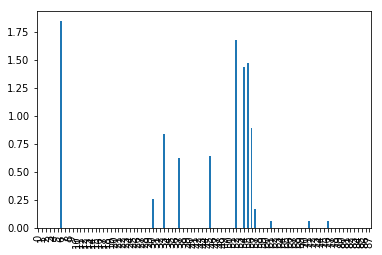

In [75]:
pileup.entropy.plot.bar()

### Mirlet7d

In [77]:
!grep -i mirlet7d ../gencode.gtf

chr13	ENSEMBL	gene	48689488	48689590	.	-	.	gene_id "ENSMUSG00000065453.3"; gene_type "miRNA"; gene_name "Mirlet7d"; level 3; mgi_id "MGI:2676796";
chr13	ENSEMBL	transcript	48689488	48689590	.	-	.	gene_id "ENSMUSG00000065453.3"; transcript_id "ENSMUST00000083519.3"; gene_type "miRNA"; gene_name "Mirlet7d"; transcript_type "miRNA"; transcript_name "Mirlet7d-201"; level 3; transcript_support_level "NA"; mgi_id "MGI:2676796"; tag "basic";
chr13	ENSEMBL	exon	48689488	48689590	.	-	.	gene_id "ENSMUSG00000065453.3"; transcript_id "ENSMUST00000083519.3"; gene_type "miRNA"; gene_name "Mirlet7d"; transcript_type "miRNA"; transcript_name "Mirlet7d-201"; exon_number 1; exon_id "ENSMUSE00000522678.2"; level 3; transcript_support_level "NA"; mgi_id "MGI:2676796"; tag "basic";


In [78]:
!samtools view -b -o ../clip/CLIP-let7d.bam CLIP-35L33G.bam chr13:48689488-48689590
!samtools view ../clip/CLIP-let7d.bam | wc -l

187


In [79]:
!samtools mpileup ../clip/CLIP-let7d.bam > ../clip/CLIP-let7d.pileup
!wc -l ../clip/CLIP-let7d.pileup

[mpileup] 1 samples in 1 input files
<mpileup> Set max per-file depth to 8000
87 ../clip/CLIP-let7d.pileup


In [80]:
!awk '$2 >= 48689488 && $2 <= 48689590 { print $0; }' ../clip/CLIP-let7d.pileup > ../clip/CLIP-let7d-gene.pileup
!tail ../clip/CLIP-let7d-gene.pileup

chr13	48689565	N	6	cccccc	>IGIIH
chr13	48689566	N	6	tttttt	:IGFIH
chr13	48689567	N	6	aaaaaa	8IFIFI
chr13	48689568	N	6	cccccc	?IGIII
chr13	48689569	N	6	tttttt	;IGIII
chr13	48689570	N	5	aaaaa	EDECD
chr13	48689571	N	6	cccccc	:GGIGG
chr13	48689572	N	6	cccccc	:GGIGG
chr13	48689573	N	6	tttttt	5GGIGG
chr13	48689574	N	6	c$c$c$c$c$c$	;GGIGG


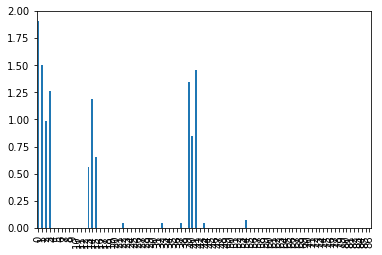

In [81]:
pileup = pd.read_csv('../clip/CLIP-let7d-gene.pileup', sep='\t', names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])
toremove = re.compile('[<>$*#^]')
pileup['matches'] = pileup['basereads'].apply(lambda x: toremove.sub('', x))

pileup['entropy'] = pileup['matches'].apply(calculate_shannon_entropy)
pileup['start'] = pileup.pos.sub(1)
pileup.head()

pileup[['chrom', 'start', 'pos', 'entropy']].to_csv('../clip/Mirlet7d_entropy.bedGraph', sep='\t', index=None, header=None)
pileup[['chrom', 'start', 'pos', 'entropy']]

pileup.entropy.plot.bar()

### Mirlet7f-1

In [82]:
!grep -i mirlet7f-1 ../gencode.gtf

chr13	ENSEMBL	gene	48691305	48691393	.	-	.	gene_id "ENSMUSG00000105621.3"; gene_type "miRNA"; gene_name "Mirlet7f-1"; level 3; mgi_id "MGI:2676798";
chr13	ENSEMBL	transcript	48691305	48691393	.	-	.	gene_id "ENSMUSG00000105621.3"; transcript_id "ENSMUST00000198652.3"; gene_type "miRNA"; gene_name "Mirlet7f-1"; transcript_type "miRNA"; transcript_name "Mirlet7f-1-201"; level 3; transcript_support_level "NA"; mgi_id "MGI:2676798"; tag "basic";
chr13	ENSEMBL	exon	48691305	48691393	.	-	.	gene_id "ENSMUSG00000105621.3"; transcript_id "ENSMUST00000198652.3"; gene_type "miRNA"; gene_name "Mirlet7f-1"; transcript_type "miRNA"; transcript_name "Mirlet7f-1-201"; exon_number 1; exon_id "ENSMUSE00001348852.2"; level 3; transcript_support_level "NA"; mgi_id "MGI:2676798"; tag "basic";


In [83]:
!samtools view -b -o ../clip/CLIP-let7f-1.bam CLIP-35L33G.bam chr13:48691305-48691393
!samtools view ../clip/CLIP-let7f-1.bam | wc -l

158


In [84]:
!samtools mpileup ../clip/CLIP-let7f-1.bam > ../clip/CLIP-let7f-1.pileup
!wc -l ../clip/CLIP-let7f-1.pileup

[mpileup] 1 samples in 1 input files
<mpileup> Set max per-file depth to 8000
97 ../clip/CLIP-let7f-1.pileup


In [85]:
!awk '$2 >= 48691305 && $2 <= 48691393 { print $0; }' ../clip/CLIP-let7f-1.pileup > ../clip/CLIP-let7f-1-gene.pileup
!tail ../clip/CLIP-let7f-1-gene.pileup

chr13	48691377	N	24	tttttttttttttttttttttttt	BIIGIGEDCGFIFGI@GHIDDIGI
chr13	48691378	N	24	aaaaaaaaaaaaaaaaaaaaaaaa	?HIFIGGGAFEFABI>GII;EIGI
chr13	48691379	N	24	cccccccccccccccccccccccc	EIIGIGGDEGGIEGI;GIIDDIGI
chr13	48691380	N	24	tttttttttttttttttttttttt	EIIGIBGGEGFIFGI@GIIBDIGI
chr13	48691381	N	24	aaaaaaaaaaaaaaaaaaaaaaaa	BEHFIGEG@FCEAGH4GII;AIDH
chr13	48691382	N	24	cccccccccccccccccccccccc	?IEGIHGG?GEGEBI=GIIDEIGG
chr13	48691383	N	24	cccccccccccccccccccccccc	EIGGIGGGAGFGFGI=GIIDGIGG
chr13	48691384	N	24	tttttttttttttttttttttttt	<IGGIHGG>GEGBGI8GII@GIGG
chr13	48691385	N	24	cccccccccccccccccccccccc	BIGGIBDD?GEGBEI=GIIBGIGG
chr13	48691386	N	24	a$a$a$a$a$a$a$a$a$a$a$a$a$a$a$a$a$a$a$a$a$a$a$a$	EIGGIFDECGFGFGI2BIIDGIGG


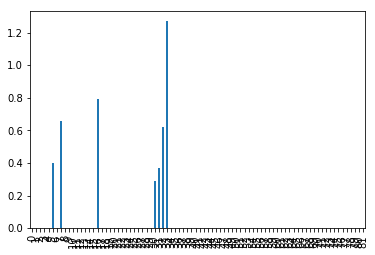

In [86]:
pileup = pd.read_csv('../clip/CLIP-let7f-1-gene.pileup', sep='\t', names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])
toremove = re.compile('[<>$*#^]')
pileup['matches'] = pileup['basereads'].apply(lambda x: toremove.sub('', x))

pileup['entropy'] = pileup['matches'].apply(calculate_shannon_entropy)
pileup['start'] = pileup.pos.sub(1)
pileup.head()

pileup[['chrom', 'start', 'pos', 'entropy']].to_csv('../clip/Mirlet7f-1_entropy.bedGraph', sep='\t', index=None, header=None)
pileup[['chrom', 'start', 'pos', 'entropy']]

pileup.entropy.plot.bar()